# Training10

In this notebook file, FirstQuarter-FullPhoto dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

MobileNetV2 pre-trained model will be load and used.

Pre-trained model's layers except its last 24 layers will be set to non-trainable.

Training will be performed in the last 24 layers of pre-trained model and the Output layer.

In this way, the experience gained by the model on very large datasets will be used in this classification problem, while its last 24 layers will be updated and fine-tuned.

This method is known as [**Fine-Tuning**](https://deeplizard.com/learn/video/5T-iXNNiwIs "deeplizard").

See also [**Transfer Learning and Fine-Tuning**](https://www.tensorflow.org/tutorials/images/transfer_learning "tensorflow").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in FirstQuarter is being read from md5 file
personDf = pd.read_pickle("../../../Data/FirstQuarter/Person.pkl")
personDf

,Name
ID,
0,Ahmed Chalabi
1,Ai Sugiyama
2,Alan Greenspan
3,Alastair Campbell
4,Allyson Felix
...,...
107,Wayne Ferreira
108,William Macy
109,Woody Allen


In [5]:
#FullPhoto Training data is being read from md5 file
trainingDf = pd.read_pickle("../../../Data/FirstQuarter/FullPhoto/Training.pkl")
trainingDf

,PersonID,ImageBGR
0,95,"[[[59, 59, 53], [58, 58, 52], [57, 56, 51], [5..."
1,63,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,94,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,10,"[[[158, 177, 174], [158, 177, 174], [158, 177,..."
4,101,"[[[43, 17, 77], [45, 21, 78], [43, 20, 72], [4..."
...,...,...
443,55,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
444,79,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
445,54,"[[[7, 0, 0], [7, 0, 0], [7, 0, 0], [7, 0, 0], ..."
446,29,"[[[0, 0, 0], [0, 0, 0], [1, 0, 0], [2, 0, 0], ..."


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

trainingX = (np.array(trainingDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
trainingX.shape

(448, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(448, 1)

In [8]:
#FullPhoto Validation data is being read from md5 file
validationDf = pd.read_pickle("../../../Data/FirstQuarter/FullPhoto/Validation.pkl")
validationDf

,PersonID,ImageBGR
0,50,"[[[60, 67, 60], [60, 67, 60], [60, 67, 60], [5..."
1,73,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,40,"[[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ..."
3,27,"[[[0, 1, 2], [0, 0, 0], [1, 1, 0], [2, 1, 0], ..."
4,18,"[[[58, 109, 149], [58, 109, 149], [58, 109, 14..."
5,75,"[[[0, 0, 3], [0, 0, 2], [0, 0, 1], [0, 0, 1], ..."
6,81,"[[[0, 1, 3], [0, 0, 3], [1, 0, 4], [4, 0, 5], ..."
7,56,"[[[251, 255, 255], [251, 255, 255], [251, 255,..."
8,111,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
9,68,"[[[10, 16, 15], [9, 15, 14], [8, 12, 12], [9, ..."


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

validationX = (np.array(validationDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
validationX.shape

(55, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(55, 1)

In [11]:
#MobileNetV2 pre-trained model is being loaded
#The original MobileNetV2 model was trained with images with size of (224, 224, 3) 
#in RGB color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/mobilenet/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Color orders were changed from BGR to RGB and pixel values were converted to [-1, 1] range
#while preparing trainingX and validationX

#Training will be performed in the last 24 layers of pre-trained model and the Output layer

model = tf.keras.applications.MobileNetV2(include_top = False, weights = 'imagenet', input_shape = ((224, 224, 3)))
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
#Number of layers of pre-trained model is being calculated except its last 24 layers
nonTrainablePart = len(model.layers) - 24
nonTrainablePart

130

In [13]:
#Pre-trained model's layers except its last 24 layers will be set to non-trainable
for layer in model.layers[:nonTrainablePart]:
    layer.trainable = False
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
#The pre-trained model is being connected to the Average Pooling layer
#A dropout layer is added to the the model to prevent overfitting,
#and the model is completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 112)               143472    
Total params: 2,401,456
Trainable params: 1,503,472
Non-trainable params: 897,984
_________________________________________________________________


In [15]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [16]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize):
        self.image, self.label = image, label
        self.batchSize = batchSize
        self.index = np.arange(self.image.shape[0])
    
    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return int(np.ceil(self.image.shape[0] / float(self.batchSize)))
    
    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        batchX = self.image[indexPart]
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #At the end of the epoch, the index array is being shuffled 
        #so that the data in the next epoch is returned in different orders
        np.random.shuffle(self.index)

In [17]:
#model is being trained with 50 epochs and 32 batchSize using GPU
with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 32),
        epochs = 50,
        validation_data = FitSequence(validationX, validationY, 32)
    )

Epoch 1/50
14/14 [==============================] - 15s 563ms/step - loss: 4.8154 - accuracy: 0.0491 - val_loss: 9.0428 - val_accuracy: 0.0545
Epoch 2/50
14/14 [==============================] - 5s 333ms/step - loss: 2.4393 - accuracy: 0.7076 - val_loss: 7.5342 - val_accuracy: 0.0727
Epoch 3/50
14/14 [==============================] - 5s 335ms/step - loss: 0.6756 - accuracy: 0.9509 - val_loss: 5.5955 - val_accuracy: 0.0727
Epoch 4/50
14/14 [==============================] - 5s 336ms/step - loss: 0.0886 - accuracy: 1.0000 - val_loss: 6.2066 - val_accuracy: 0.0364
Epoch 5/50
14/14 [==============================] - 5s 334ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 6.3693 - val_accuracy: 0.0545
Epoch 6/50
14/14 [==============================] - 5s 333ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 6.0595 - val_accuracy: 0.0727
Epoch 7/50
14/14 [==============================] - 5s 333ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 5.8145 - val_accuracy: 0.0909
Epoch

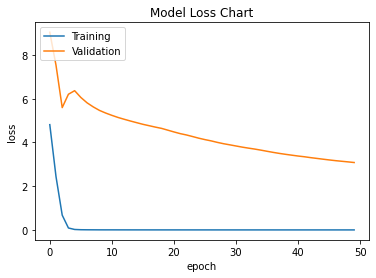

In [18]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

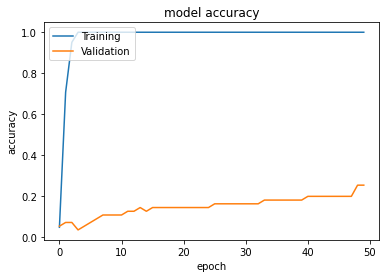

In [19]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [20]:
#FullPhoto Test data is being read from md5 file
testDf = pd.read_pickle("../../../Data/FirstQuarter/FullPhoto/Test.pkl")
testDf

,PersonID,ImageBGR
0,72,"[[[0, 0, 3], [0, 0, 3], [0, 0, 3], [0, 0, 3], ..."
1,37,"[[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], ..."
2,21,"[[[76, 11, 3], [76, 11, 3], [77, 11, 3], [78, ..."
3,104,"[[[150, 165, 251], [148, 164, 247], [150, 164,..."
4,65,"[[[48, 69, 77], [49, 70, 78], [49, 68, 76], [4..."
5,88,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6,97,"[[[169, 168, 172], [168, 167, 171], [168, 167,..."
7,87,"[[[82, 82, 96], [82, 82, 95], [83, 81, 93], [8..."
8,105,"[[[0, 5, 74], [0, 6, 72], [1, 6, 71], [2, 6, 7..."
9,67,"[[[0, 2, 0], [0, 2, 0], [0, 2, 0], [0, 2, 0], ..."


In [21]:
#testX is being extracted from testDf as wanted shape

#Since the pre-trained model to be used in this notebook, MobileNetV2, trained with RGB color ordered images by default,
#all images are being converted from BGR color order to RGB color order.
#[:, :, :, ::-1] code swaps the first and last channels of each image in a numpy array containing 3 channel images
#This way all images can be converted from BGR color order to RGB color order in one line

#Pixel values are being converted  to the [-1, 1] range with the simplest method (pixel / 127.5 - 1)

testX = (np.array(testDf.ImageBGR.values.tolist())[:, :, :, ::-1] / 127.5) - 1
testX.shape

(57, 224, 224, 3)

In [22]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(57, 1)

In [23]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 32))

2/2 [==============================] - 3s 2s/step - loss: 2.5898 - accuracy: 0.4386


In [24]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 2.589834690093994


In [25]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.4385964870452881


# Training10 Inference

By looking at the charts, it can be said that training results in overfitting.

A similar architecture was trained with same data in the Training2 notebook file without the Transfer Learning method.

And same model was trained with the same data in the Training6 notebook file without fine-tuning method.

Although the results are much better than those in the Training2 notebook file, a success of about 25% on the Validation data and about 100% on the Training data indicates overfitting.

In this case, it can be said that overfitting is caused by too few images for each person.

Apparently fine-tuning did not achieve the desired success due to insufficient data.

However, this example clearly demonstrates the power of Transfer Learning.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.

Since there is no expectation from this dataset, which contains very few images for each Person.

This training will not be focussed on.